__Lab 07 - SCA (Part 4): Template Matching Attack__

Student Names: Alec Braynen and Jasmin Kuar

Group Number: Group 7

# Setup

## Importing Python Libraries & Setup ChipWhisperer

Begin by importing the required libraries, connecting to the scope, and applying the default setup.

Note: set the number of ADC samples to capture to 5000: `scope.adc.samples = 5000`

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import chipwhisperer as cw
import numpy as np
import scipy.stats as sp
from tqdm import tnrange

In [2]:
# This is an API for your CW's scope (in the CAPTURE section)
scope = cw.scope()

# This is an API for your CW's target (in the TARGET section)
target = cw.target(scope, cw.targets.SimpleSerial)

# Sets the scope's default settings
scope.default_setup()

# Cap the max num of power trace samples to collect
scope.adc.samples = 5000

# Prints the scope settings
print(scope)

print("✔️ OK to continue!")

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 24
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = None
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 5000
glitch = 
    repeat     = 0
    ext_offset = 0

✔️ OK to continue!


Next, compile the "sam.c" firmware:

In [3]:
%%bash
cd ../Firmware
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-07/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Removing old files
rm -f -- sam-CWNANO.hex
rm -f -- sam-CWNANO.elf
rm -f -- sam-CWNANO.map
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- sam.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- sam.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- sam.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
make[1]: '.dep' is up to date.
make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-07/Firmware'
make begin gccversion build sizeafter
make[1]: Entering directory '/home/phs/Desktop/phs-labs/PHS-Lab-07/Firmware'
SS_VER set to SS_VER_1_1

+--------------------------------------------------------

Welcome to another exciting ChipWhisperer target build!!


arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release

make[1]: Leaving directory '/home/phs/Desktop/phs-labs/PHS-Lab-07/Firmware'


Program the microcontroller with the "sam-CWNANO" hex file:

In [4]:
prog = cw.programmers.STM32FProgrammer
fw_path = '../Firmware/sam-CWNANO.hex'
cw.program_target(scope, prog, fw_path)

print("✔️ OK to continue!")

Serial baud rate = 115200
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5947 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5947 bytes
Serial baud rate = 38400
✔️ OK to continue!


## Creating Function to Reset Target

This function allows you to reset the target from your code:

__This function is completed, do not change__

In [5]:
import time
def reset_target(): 
    target.flush()
    scope.io.nrst = 'low'
    time.sleep(0.2)
    scope.io.nrst = 'high'
    time.sleep(0.01)

def readall_target():
    ret = ""
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(timeout=10)
        time.sleep(0.1)
        num_char = target.in_waiting()
    return ret

print("✔️ OK to continue!")

✔️ OK to continue!


Call this function here (print the output of readall_target())

In [6]:
# Should print start-up test from the device
reset_target()
print(readall_target())
print("✔️ OK to continue!")


✔️ OK to continue!


# Testing `e` function with 3 test vectors

Begin by testing the `e` function. The function takes in a 16-bytes array, then converts it to a 64-bits binary array, perform the SAM algorithm, and returns the result.

The 16-bytes array is the exponent of the modular multiplication in *little endian bytearray*. To make things easier, create a function that converts an integer to bytearray of size 16-bytes in little endian.

Note: you are allowed to use built-in functions.

__Complete missing parts__

In [7]:
# Function: int_to_bytes()
#   Input:  'x'      - integer number
#   Input:  'n'      - length of the bytes array (default = 16)
#   Input:  'endian' - endian format of the bytes array: "little" (default) or "big"
#   Output: 'b'      - return the bites array of size 'n' in respective 'endian' format
def int_to_bytes(x, n=16, endian="little"):
    b = x.to_bytes(n, byteorder = endian)
    return b

Test your function:

In [8]:
# try different input values 'x'
x = 0x123456789ABCDEF

# do not change these lines below:
b = int_to_bytes(x)

print("Output:", b)

b_hex = b[::-1].hex()
print("Output (hex):", b_hex)

ans='0'*(34-len(hex(x)))+hex(x)[2:]
print("Answer (hex):", ans)

# if all these tests pass, then your function works
assert (type(b) == bytes or type(b) == bytearray), "incorrect output format. Myst be bytes or bytearray"
assert (len(b) == 16), "the size of the output must be 16 bytes"
assert (b_hex == ans), "the output must equal to the bytearray little endian of the input"
print("✔️ OK to continue!")

Output: b'\xef\xcd\xab\x89gE#\x01\x00\x00\x00\x00\x00\x00\x00\x00'
Output (hex): 00000000000000000123456789abcdef
Answer (hex): 00000000000000000123456789abcdef
✔️ OK to continue!


Now, we can run the firmware's `e` function. 

Let's make a function that will send an exponent to the SAM algorithm in firmware's `e` function and then return its output (`simpleserial_read`).

__Complete missing parts__

In [9]:
# Function: run_firmware_e()
#   Input:  'exp_int' - integer exponent
#   Output: 'r_int'   - returns output from the firmware 'e' function as int
def run_firmware_e(exp_int: int) -> int:
    # reset target
    reset_target()

    # encode integer as little endian bytearray of 16-bytes
    # hint: int_to_bytes
    exp_bytes = int_to_bytes(exp_int)
    
    # send the encoded exponent to function 'e'
    target.simpleserial_write('e', exp_bytes)
    
    # wait for the output to be ready
    while target.in_waiting() == 0:
        pass
    
    # read output from device
    r = target.simpleserial_read('r', 16)
    
    # convert bytearray (little endian) to int
    r_int = int.from_bytes(r, 'little')
    
    # return 
    return r_int

Test your function and check the result to the Python's built-in `pow()` function. Note that `pow()` has an optional 3rd argument for the modulus: https://docs.python.org/3/library/functions.html#pow

The base and modulus in the "sam.c" file are hardcoded as 0x42 and 0x17, respectively.

Confirm functionality with at least 3 test vectors, and include these outputs in your report.

__Remember:__ the `e` function uses 64-bit arithmetic. Do not give inputs that will overflow!

__Complete missing parts__

In [10]:
# Test 'e' #1
x = 0x000000000000001F

out = run_firmware_e(x)

ans = pow(0x42, x, 0x17)

print("Output:", out)
print("Answer:", ans)


# do not change these lines below:
assert out == ans
print("✔️ OK to continue!")

Output: 5
Answer: 5
✔️ OK to continue!


In [11]:
# Test 'e' #2
x = 0x0000000000000FFF

out = run_firmware_e(x)

ans = pow(0x42, x, 0x17)

print("Output:", out)
print("Answer:", ans)


# do not change these lines below:
assert out == ans
print("✔️ OK to continue!")

Output: 19
Answer: 19
✔️ OK to continue!


In [12]:
# Test 'e' #2
x = 0x00000000000FFFFF

out = run_firmware_e(x)

ans = pow(0x42, x, 0x17)

print("Output:", out)
print("Answer:", ans)


# do not change these lines below:
assert out == ans
print("✔️ OK to continue!")

Output: 22
Answer: 22
✔️ OK to continue!


Once you confirm the functionality of the SAM algorithm in the firmware, we can move on to the SCA attack

# Attacking `f` function: generate power trace

Since we are going to run the "SAM" algorithm many times, the `e` function is too slow. Thus, we provided an equivalent function on the firmware with simpleserial command `f`. The `f` function is easier to attack because it uses integer (i.g., 32-bits) arithmetic and does not return a value over serial.

For the attack, we need to generate power traces from the CW. Let's create a function for this as in previous labs or the PHS-Tutorial-03.

__Remember #1:__ the input to the CW must be formated to little endian bytearray of size 16-bytes as you did for `e`.

__Remember #2:__ the `f` function uses 32-bit arithmetic. Do not give inputs that will overflow!

__Complete missing parts__

In [13]:
# Function: run_firmware_e()
#   Input:  'exp_int' - integer exponent
#   Output: 'trace'   - power trace collected from the CW as a Numpy Array
def get_pwr_trace(exp_int: int) -> bytearray:
    # reset target and read start-up text
    reset_target()
    
    scope.arm()
    
    # encode integer as little endian bytearray of 16-bytes
    # hint: int_to_bytes
    
    exp_bytes = int_to_bytes(exp_int)
    
    # send the encoded exponent to function 'e'
    target.simpleserial_write('f', exp_bytes)
    
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    
    return trace

print("✔️ OK to continue!")

✔️ OK to continue!


Below, test your `get_pwr_trace` function. Just test 1 input. Make sure it correctly sends data and captures the power trace.

In [14]:
trace = get_pwr_trace(0x000000000000001F)

print(trace)

# do not change these lines below:
assert type(trace) == np.ndarray
assert len(trace)  > 0
print("✔️ OK to continue!")

[0.0703125  0.3828125  0.02734375 ... 0.32421875 0.16015625 0.04296875]
✔️ OK to continue!


Once you have confirmed functionality, use CW Nano to acquire 20-30 traces for the __same__ exponent key from the `f` function. Then, average (sample-wise) the traces, and plot them using pyplot.

Hint: this is similar to Lab 4, but instead of 32-iterations, just 20-30 is enough.

In [15]:
# Function: get_samplewise_trace(x)
#   Input:  'x' - integer exponent
#   Output: 'samplewise'   - Samplewise Average Numpy Array
def get_samplewise_trace(x):
    tracelist = []
    i = 0
    while i < 30:
        trace = get_pwr_trace(x)
        tracelist.append(trace)
        i = i + 1
    
    tracelist = np.asarray(tracelist)
    samplewise = tracelist.mean(axis=0)
    
    return samplewise

In [16]:
# Function: plot_trace(x)
#   Input:  'trace' - Numpy array
def plot_trace(trace):
    plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

    # plots the data
    plt.plot(trace, color="b")

    # format your plots
    plt.title("Power Trace")            # adds title
    plt.xlabel("Sample")  # adds x-axis label
    plt.ylabel("Power")  

    plt.show()
    print("✔️ OK to continue!")
    

<IPython.core.display.Javascript object>


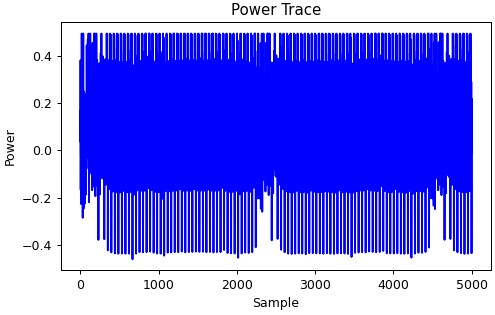

✔️ OK to continue!


In [17]:
plot_trace(get_samplewise_trace(1)) #plot trace for investigation

<IPython.core.display.Javascript object>


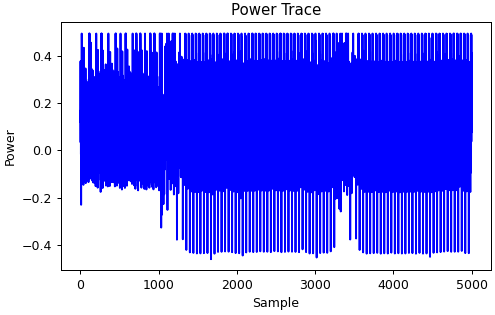

✔️ OK to continue!


In [18]:
plot_trace(get_samplewise_trace(1000)) #plot trace for investigation

In [ ]:
plot_trace(get_samplewise_trace(10000)) #plot trace for investigation

<IPython.core.display.Javascript object>


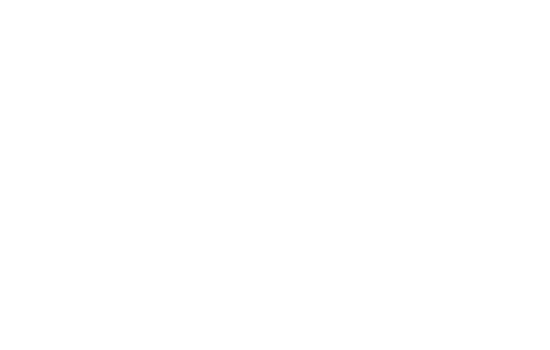

✔️ OK to continue!


In [20]:
plot_trace(get_samplewise_trace(40000)) #plot trace for investigation

<IPython.core.display.Javascript object>


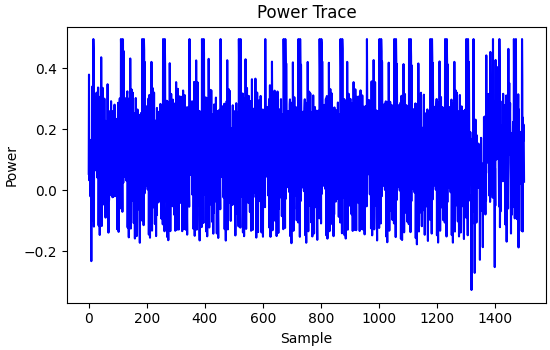

✔️ OK to continue!


<IPython.core.display.Javascript object>


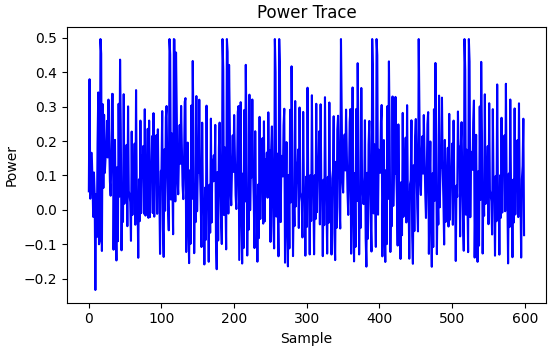

✔️ OK to continue!


<IPython.core.display.Javascript object>


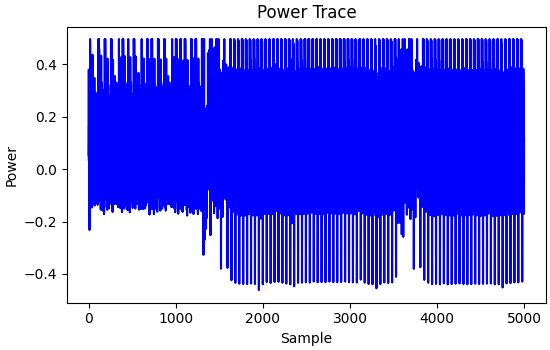

✔️ OK to continue!


In [316]:
samplewise = get_samplewise_trace(40000) 



plot_trace(samplewise[0:1500])
plot_trace(samplewise[0:600]) 

plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(samplewise, color="b")

# format your plots
plt.title("Power Trace")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")  

plt.show()
print("✔️ OK to continue!")
plt.savefig("../Figures/avg_trace.pdf")


<span class="mark">For the following portions, we ONLY need the sample-wise average power trace, not the 20-30 individual traces. Thus, for the following steps/sections, when we say "trace" or "traces" or "signal" we are referring to this sample-wise average power trace.</span>

# Attacking `f` function: find template

Using any of the techniques you have previously worked with, identify a portion of the trace which represents the processing of a 1. Define a region around this sample point which will serve as the template. Save this region of your trace in a variable named `T` (for template). Plot your template.

<IPython.core.display.Javascript object>


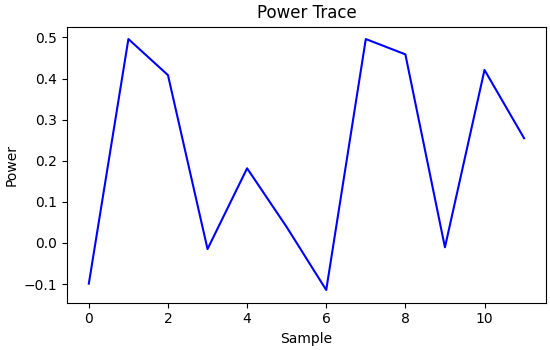

✔️ OK to continue!


In [317]:
T = samplewise[183:195]

# plot_trace(T)

plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(T, color="b")

# format your plots
plt.title("Power Trace")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")  

plt.show()
print("✔️ OK to continue!")
plt.savefig("../Figures/template.pdf")

# Attacking "f" function: SAD template matching

Implement SAD template matching to compare this defined template `T` against the average trace from section 3.

In [318]:
def template_matching(trace):
    sad = []
    for i in range(len(trace)):
        if(i+(len(T)-1) == len(trace)):
            break
        else:
            temp = sum(abs(trace[i:i+len(T)]-T))
            sad.append(temp)
    return sad

<IPython.core.display.Javascript object>


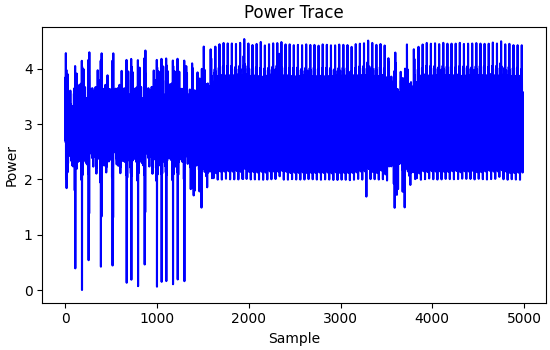

✔️ OK to continue!


In [319]:
y = template_matching(samplewise)

# plot_trace(y)

plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(y, color="b")

# format your plots
plt.title("Power Trace")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Sum of Absolute Distance")  

plt.show()
print("✔️ OK to continue!")
plt.savefig("../Figures/sad_output.pdf")

# Attacking "f" function: binary match vector `bmv`

Determine a threshold for the SAM results to discern matches to the template (i.e., values under the threshold) and collect this in a binary match vector named `bmv`. Plot the resulting `bmv`.

Hint: the plot should look like a barcode, with spikes in every position where there was a match to the template `T`.

In [320]:
def binary_match(tracelist):
    bmv = []
    pos_list = []
    
    for i in range(len(tracelist)):
        if tracelist[i] < 1.45: # threshold
            bmv.append(1)
            pos_list.append(i)
        else:
            bmv.append(0)
    key = recovery_key(pos_list)
    print(key)
    return bmv, key


# This needs to be improved but we're out of time. I really don't like this code.    
def recovery_key(poslist):
    key = []
    
    for i in range(len(poslist)):
        if i + 1 > len(poslist)-1:
            break
        if poslist[i + 1] - poslist[i] > 10:
            key.append(0)
        else:
            key.append(1)
            i = i + 1
            
    formatted_key = ""
    
    j = 0
    while j < len(key):
        if key[j] == 0:
            formatted_key = formatted_key + "0"
        if key[j] == 1:
            formatted_key = formatted_key + "1"
            j = j + 1
        j = j + 1
    formatted_key = formatted_key + "0" # lsb
        
        
    return formatted_key


001110001000000


<IPython.core.display.Javascript object>


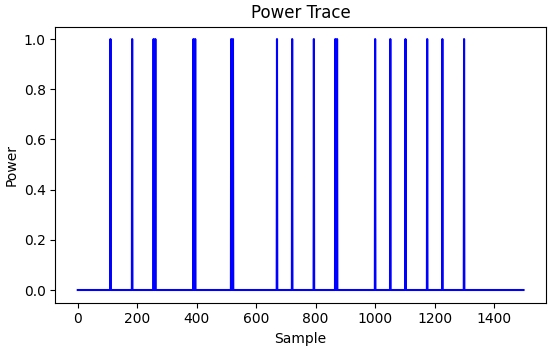

✔️ OK to continue!


In [321]:
bmv, recovered_key = binary_match(y)

# plot_trace(bmv[0:1500])

plt.figure(figsize=(5.5, 3.5), constrained_layout=True)

# plots the data
plt.plot(bmv[0:1500], color="b")

# format your plots
plt.title("Power Trace")            # adds title
plt.xlabel("Sample")  # adds x-axis label
plt.ylabel("Power")  

plt.show()
print("✔️ OK to continue!")
plt.savefig("../Figures/bmv.jpg")

# Attacking "f" function: find the key

Using the BMV, you should identify regions where the key-bits being processed are 0 or 1. The greater the spacing between the matches, the longer the intervening operations took. Per the algorithm above, long-running operations occur when the key-bit is a 1 (if(exp\_bin[--i] == 1)). You should now be able to visually inspect this resulting signal and read off the value of the key (exponent) directly from this plot. About how many samples were there in "1" regions? "0" regions?

Print your recovered key found, the actual key, and the number of matching (correct) bits. Remember that SAM algorithm skips the MSB `1` in the exponent. An example output is shown in the lab manual.

__Undergraduate Students:__ you may do this manually by looking at the `bmv` plot from section 6, then write it on . Or you can also do it automated as the graduate students.

__Graduate Students:__ you must automate this process of analyzing the BMV from step 6 and print the resulting key.  

In [322]:
def print_results(recovered_key, actual_key):
    num_same = 0
    print(len(recovered_key), len(actual_key))
    for i in range(len(actual_key)):
        if recovered_key[i] == actual_key[i]:
            num_same = num_same + 1
    print("Recovered Key: ", recovered_key[0:len(actual_key)])
    print("Actual Key: ", actual_key)
    print("Number of Matching Bits: ", num_same)

In [323]:
actual_key = "001110001000000"
print_results(recovered_key, actual_key)

print("Recovered Key (hex) = 0x%04x"%int(recovered_key))
print("Actual Key (hex) = 0x%04x"%int(actual_key))


15 15
Recovered Key:  001110001000000
Actual Key:  001110001000000
Number of Matching Bits:  15
Recovered Key (hex) = 0x10271371e40
Actual Key (hex) = 0x10271371e40


# Diconnect Scope/Target

Disconnect the CW's scope and target:

In [29]:
scope.dis()
target.dis()